In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
from ses_network_3_0 import SESNetwork
#from extraction_works.ses_network_2_0_copy import SESNetwork
from utils import make_input, LatentSpace, get_sample_from_num_swaps, get_cos_sim_np, get_cos_sim_torch, test_network, get_ordered_weights

In [33]:
network_parameters = {}

network_parameters["hebbian_filter"] = False

network_parameters["duration_phase_A"] = 1000
network_parameters["duration_phase_B"] = 1500

network_parameters["sleep_duration_A"] = 10
network_parameters["sleep_duration_B"] = 10
network_parameters["reset_dayly"] = True

network_parameters["regions"] = ["sen", "mtl_sparse", "mtl_dense", "mtl", "ctx"]

network_parameters["mtl_pattern_complete_iterations"] = 10
network_parameters["mtl_dense_pattern_complete_iterations"] = 10
network_parameters["mtl_sparse_pattern_complete_iterations"] = 10
network_parameters["ctx_pattern_complete_iterations"] = 10
network_parameters["mtl_generate_pattern_complete_iterations"] = 10

network_parameters["max_semantic_charge_replay"] = 1
network_parameters["max_semantic_charge_input"] = 2

network_parameters["sen_num_subregions"] = 1
network_parameters["sen_size_subregions"] = torch.tensor([100])
network_parameters["sen_sparsity"] = torch.tensor([0.2])
network_parameters["sen_sparsity_sleep"] = torch.tensor([0.2])

network_parameters["ctx_num_subregions"] = 2
network_parameters["ctx_size_subregions"] =  torch.tensor([100, 300])
network_parameters["ctx_sparsity"] = torch.tensor([0.2, 1/30])
network_parameters["ctx_sparsity_sleep"] = torch.tensor([0.1, 1/30])

network_parameters["mtl_num_subregions"] = 2
network_parameters["mtl_size_subregions"] =  torch.tensor([100, 100])
network_parameters["mtl_sparsity"] = torch.tensor([0.2, 0.1])
network_parameters["mtl_sparsity_sleep"] = torch.tensor([0.1, 0.05])

network_parameters["mtl_dense_num_subregions"] = 1
network_parameters["mtl_dense_size_subregions"] = torch.tensor([100])
network_parameters["mtl_dense_sparsity"] = torch.tensor([0.2])
network_parameters["mtl_dense_sparsity_sleep"] = torch.tensor([0.1])

network_parameters["mtl_sparse_num_subregions"] = 1
network_parameters["mtl_sparse_size_subregions"] = torch.tensor([100])
network_parameters["mtl_sparse_sparsity"] = torch.tensor([0.1])
network_parameters["mtl_sparse_sparsity_sleep"] = torch.tensor([0.05])

network_parameters["mtl_dense_sen_projection"] = False
network_parameters["mtl_dense_sen_sparsity"] = 0.5

network_parameters["ctx_mtl_quick_lmbda"] = 1e-2
network_parameters["max_pre_ctx_mtl_quick"] = np.inf
network_parameters["max_post_ctx_mtl_quick"] = 1

network_parameters["ctx_mtl_sparsity"] = 0.5
network_parameters["ctx_mtl_mean"] = 0.03
network_parameters["ctx_mtl_std"] = 0.001
network_parameters["ctx_mtl_lmbda"] = 5e-4
network_parameters["ctx_mtl_size"] = 2
network_parameters["max_pre_ctx_mtl"] = np.inf
network_parameters["max_post_ctx_mtl"] = 1

network_parameters["ctx_mtl_sparse_mean"] = 0.07
network_parameters["ctx_mtl_sparse_std"] = 0.001
network_parameters["ctx_mtl_sparse_lmbda"] = 5e-4
network_parameters["max_pre_ctx_mtl_sparse"] = np.inf
network_parameters["max_post_ctx_mtl_sparse"] = 1

network_parameters["ctx_mtl_dense_sparsity"] = 0.5
network_parameters["ctx_mtl_dense_g"] = 0.01

network_parameters["mtl_mtl_lmbda"] = 5e-3
network_parameters["max_pre_mtl_mtl"] = np.inf
network_parameters["max_post_mtl_mtl"] = np.inf

network_parameters["mtl_dense_mtl_dense_lmbda"] = 5e-3
network_parameters["max_pre_mtl_dense_mtl_dense"] = np.inf
network_parameters["max_post_mtl_dense_mtl_dense"] = np.inf

network_parameters["mtl_sparse_mtl_sparse_lmbda"] = 5e-3
network_parameters["max_pre_mtl_sparse_mtl_sparse"] = np.inf
network_parameters["max_post_mtl_sparse_mtl_sparse"] = np.inf

network_parameters["ctx_ctx_sparsity"] = 0.05
network_parameters["ctx_ctx_g"] = 1e-4
network_parameters["ctx_ctx_lmbda"] = 5e-4
network_parameters["max_pre_ctx_ctx"] = 1
network_parameters["max_post_ctx_ctx"] = np.inf

network_parameters["mtl_sparse_ctx_mean"] = 0.03
network_parameters["mtl_sparse_ctx_std"] = 0.001
network_parameters["mtl_sparse_ctx_lmbda"] = 5e-3
network_parameters["max_pre_mtl_sparse_ctx"] = np.inf
network_parameters["max_post_mtl_sparse_ctx"] = 1


recording_parameters = {}
recording_parameters["regions"] = ["sen", "mtl_hat", "mtl_dense", "mtl_sparse", "mtl_sparse_hat", "mtl", "ctx", "ctx_hat"]
recording_parameters["rate_activity"] = 1
#recording_parameters["connections"] = ["mtl_mtl", "ctx_mtl", "ctx_ctx", "ctx_mtl_quick", "mtl_sparse_ctx"]
recording_parameters["connections"] = ["ctx_mtl"]
recording_parameters["rate_connectivity"] = 1

In [34]:
input_params = {}
input_params["num_days"] = 1500
input_params["day_length"] = 40
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 4

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]

'''
latent_specs["num"] = 5
latent_specs["total_sizes"] = [20, 20, 20, 20, 20]
latent_specs["act_sizes"] = [10, 10, 10, 10, 10]
latent_specs["dims"] = [2, 2, 2, 2, 2]
'''

'\nlatent_specs["num"] = 5\nlatent_specs["total_sizes"] = [20, 20, 20, 20, 20]\nlatent_specs["act_sizes"] = [10, 10, 10, 10, 10]\nlatent_specs["dims"] = [2, 2, 2, 2, 2]\n'

In [35]:
def test_network(net, input_params, print_rate=1):
  input, input_episodes, input_latents = make_input(**input_params)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day], debug=False)
      net.sleep()
  return input, input_episodes, input_latents, net

In [36]:
#latent_specs["prob_list"] = [0.05 if i==j else 0.05/9 for i in range(10) for j in range(10)]
#latent_specs["prob_list"] = [1/100 for i in range(10) for j in range(10)]
#latent_specs["prob_list"] = [1/32 for i in range(32)]

latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
#latent_specs["prob_list"] = [0.1 if i==j else 0.1/4 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
network = SESNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)
#torch.save(network, "network.pt")

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450


In [115]:
#torch.save(network, "network_1500.pt")
netwok = torch.load("network_1500.pt", weights_only=False)

In [8]:
network.max_semantic_charge = 1

In [37]:
input_params = {}
input_params["num_days"] = 500
input_params["day_length"] = 40
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 8

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]

'''
latent_specs["num"] = 5
latent_specs["total_sizes"] = [20, 20, 20, 20, 20]
latent_specs["act_sizes"] = [10, 10, 10, 10, 10]
latent_specs["dims"] = [2, 2, 2, 2, 2]
'''

'\nlatent_specs["num"] = 5\nlatent_specs["total_sizes"] = [20, 20, 20, 20, 20]\nlatent_specs["act_sizes"] = [10, 10, 10, 10, 10]\nlatent_specs["dims"] = [2, 2, 2, 2, 2]\n'

In [38]:
#latent_specs["prob_list"] = [0.05 if i==j else 0.05/9 for i in range(10) for j in range(10)]
#latent_specs["prob_list"] = [1/100 for i in range(10) for j in range(10)]
#latent_specs["prob_list"] = [1/32 for i in range(32)]

latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
#latent_specs["prob_list"] = [0.1 if i==j else 0.1/4 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
#network = SESNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)
#torch.save(network, "network.pt")

0
50
100
150
200
250
300
350
400
450


In [43]:
ctx_mtl_rec = torch.stack(network.connectivity_recordings["ctx_mtl"], axis=0)[:, ordered_indices_ctx[:100]]

'\nplt.ylabel("Post Neuron (CTX)", fontsize=20)\nplt.xlabel("Pre Neuron (MTL)", fontsize=20)\n\nplt.xticks(np.arange(-0.5, 100, 1), minor=True)\nplt.yticks(np.arange(-0.5, 100, 1), minor=True)\nplt.grid(which=\'minor\', color=\'black\', linestyle=\'-\', linewidth=0.1)\nplt.axvline(x=99.5, linestyle=\'dashed\', color=\'white\', linewidth=0.5)\nplt.xticks([])\nplt.yticks([])\n'

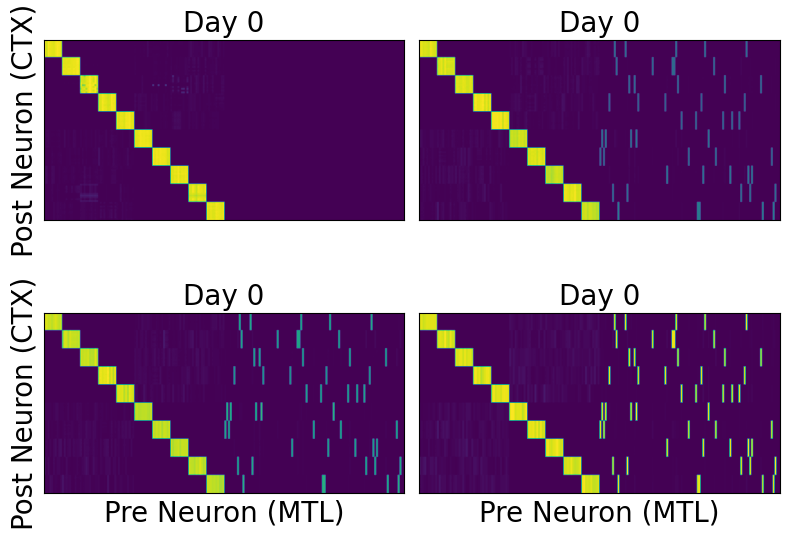

In [127]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharey=True, sharex=True)


axs[0, 0].imshow(ctx_mtl_rec[40000])
axs[0, 1].imshow(ctx_mtl_rec[85000])
axs[1, 0].imshow(ctx_mtl_rec[90000])
axs[1, 1].imshow(ctx_mtl_rec[-1])

axs[0, 0].set_title("Day 0", fontsize=20)
axs[0, 1].set_title("Day 0", fontsize=20)
axs[1, 0].set_title("Day 0", fontsize=20)
axs[1, 1].set_title("Day 0", fontsize=20)

axs[0, 0].set_yticks([])
[ax_i.set_xticks([]) for ax in axs for ax_i in ax]

axs[0, 0].set_ylabel("Post Neuron (CTX)", fontsize=20)
axs[1, 0].set_ylabel("Post Neuron (CTX)", fontsize=20)
axs[1, 0].set_xlabel("Pre Neuron (MTL)", fontsize=20)
axs[1, 1].set_xlabel("Pre Neuron (MTL)", fontsize=20)




plt.tight_layout()
'''
plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (MTL)", fontsize=20)

plt.xticks(np.arange(-0.5, 100, 1), minor=True)
plt.yticks(np.arange(-0.5, 100, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.axvline(x=99.5, linestyle='dashed', color='white', linewidth=0.5)
plt.xticks([])
plt.yticks([])
'''

(array([1.773e+04, 8.430e+02, 3.180e+02, 3.500e+01, 3.800e+01, 1.600e+01,
        0.000e+00, 9.000e+00, 1.000e+00, 0.000e+00, 5.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+0

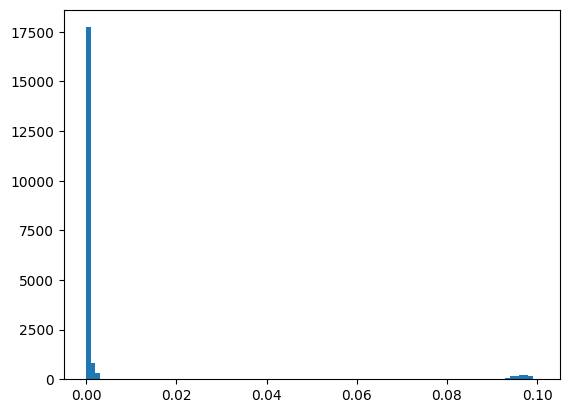

In [72]:
plt.hist(ctx_mtl_rec[40000].flatten(), bins=100)

([], [])

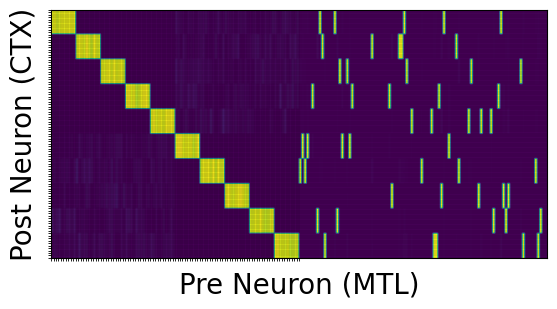

In [42]:
plt.imshow(network.ctx_mtl[ordered_indices_ctx[:100]])
plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (MTL)", fontsize=20)

plt.xticks(np.arange(-0.5, 100, 1), minor=True)
plt.yticks(np.arange(-0.5, 100, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])

Text(0.5, 0, 'Neuron (Pre)')

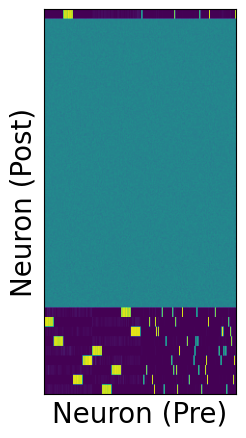

In [28]:
_, order_ctx_ctx, w_ctx_ctx = get_ordered_weights(network.ctx_ctx[ordered_indices_ctx], order_columns=True)
_, order_mtl_sparse_ctx_A, w_mtl_sparse_ctx = get_ordered_weights(network.mtl_sparse_ctx)
_, order_mtl_sparse_ctx_B, w_mtl_sparse_ctx = get_ordered_weights(w_mtl_sparse_ctx.T)
_, order_mtl_sparse_ctx_C, w_mtl_sparse_ctx = get_ordered_weights(w_mtl_sparse_ctx.T)
_, order_ctx_mtl, w_ctx_mtl = get_ordered_weights(network.ctx_mtl)
_, order_ctx_mtl_sparse_A, w_ctx_mtl_sparse = get_ordered_weights(network.ctx_mtl_sparse)
_, order_ctx_mtl_sparse_B, w_ctx_mtl_sparse = get_ordered_weights(w_ctx_mtl_sparse.T)


fig = plt.figure(figsize=((5, 5)))
plt.imshow(w_ctx_mtl)
plt.xticks([])
plt.yticks([])
plt.ylabel("Neuron (Post)", fontsize=20)
plt.xlabel("Neuron (Pre)", fontsize=20)

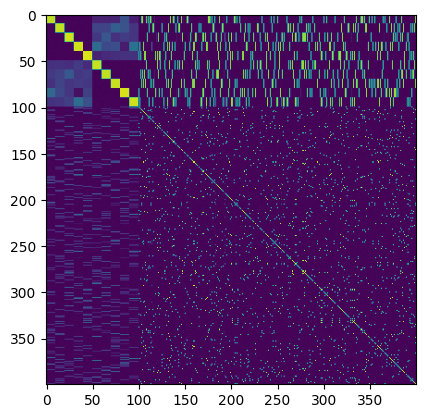

In [42]:
plt.imshow(network.ctx_ctx[ordered_indices_ctx][:, ordered_indices_ctx])

In [22]:
torch.stack(network.activity_recordings["mtl"], axis=0)[network.sleep_indices_A][-2].sum()

tensor(30.)

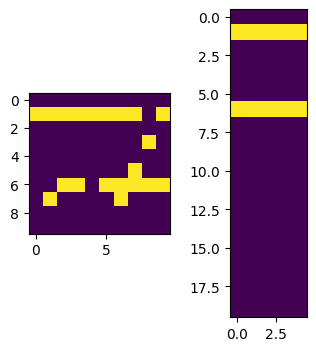

In [95]:
mtl = torch.stack(network.activity_recordings["mtl"], axis=0)[network.awake_indices][-11]

fig, ax = plt.subplots(1, 2, figsize=(4, 4))
ax[0].imshow(mtl[:100].reshape((-1, 10)))
ax[1].imshow(mtl[100:][ordered_indices_sparse[:100]].reshape((-1, 5)))

'\nplt.xticks([0, 10, 20, 30, 40], fontsize=18)\nplt.ylabel("Neuron", fontsize=20)\nplt.xlabel("Time", fontsize=20)\nplt.axvline(21.5, lw=0.5, color=\'white\')\nplt.axvline(22.5, lw=0.5, color=\'white\')\n'

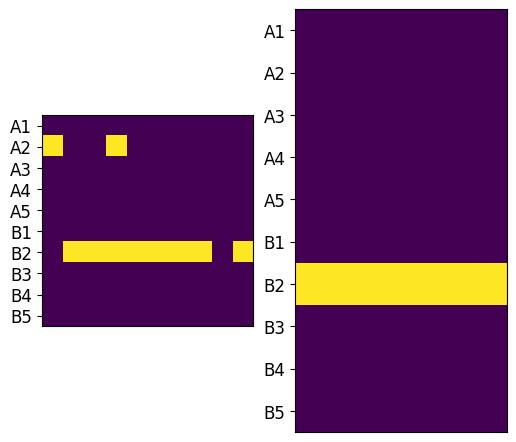

In [112]:
#mtl = network.mtl_generate(semantic_charge=1)
mtl = torch.stack(network.activity_recordings["mtl"], axis=0)[network.sleep_indices_A][-5]
fig, ax = plt.subplots(1, 2, figsize=(6, 6))
ax[0].imshow(mtl[:100].reshape((-1, 10)))
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].imshow(mtl[100:][ordered_indices_sparse[:100]][:50].reshape((-1, 5)))


# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]
ax[0].set_yticks(positions, labels, fontsize=12)
ax[1].set_yticks(positions, labels, fontsize=12)

'''
plt.xticks([0, 10, 20, 30, 40], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)
plt.axvline(21.5, lw=0.5, color='white')
plt.axvline(22.5, lw=0.5, color='white')
'''

(array([330.,  10.,   1.,   2.,  12.,  35.,   0.,   0.,   0.,  10.]),
 array([0.        , 0.09538198, 0.19076395, 0.28614593, 0.3815279 ,
        0.47690988, 0.57229185, 0.66767383, 0.7630558 , 0.85843778,
        0.95381975]),
 <BarContainer object of 10 artists>)

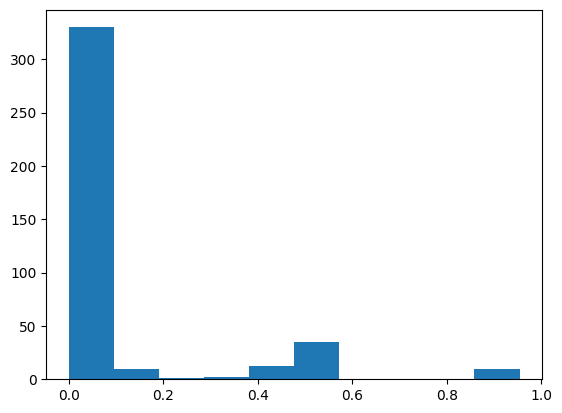

In [20]:
plt.hist((network.ctx_mtl @ torch.stack(network.activity_recordings["mtl"], axis=0)[network.sleep_indices_A][-3]).flatten())

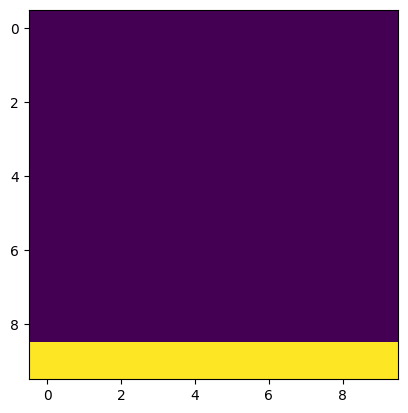

In [26]:
plt.imshow(torch.stack(network.activity_recordings["ctx"], dim=0)[network.sleep_indices_A][-2, ordered_indices_ctx[:100]].reshape(-1, 10))


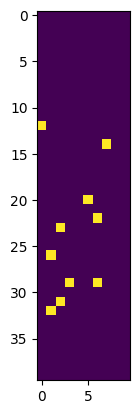

In [17]:
plt.imshow(torch.stack(network.activity_recordings["ctx"], dim=0)[network.sleep_indices_A][-2].reshape(-1, 10))


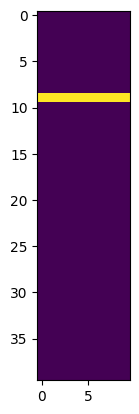

In [27]:
plt.imshow(torch.stack(network.activity_recordings["ctx"], dim=0)[network.sleep_indices_A][-2, ordered_indices_ctx].reshape(-1, 10))


In [ ]:
plt.hist((network.ctx_mtl @ torch.stack(network.activity_recordings["ctx"], axis=0)[network.sleep_indices_A][-3]).flatten())

In [39]:
X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_sparse = torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_dense = torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)

In [40]:
# Flatten time
days, day_length, num_latents = X_latent_AB.shape
_, num_neurons_ctx = X_ctx.shape
_, num_neurons_sparse = X_mtl_sparse.shape
_, num_neurons_dense = X_mtl_dense.shape

latents_flat = X_latent_AB.reshape(-1, num_latents).float()    # shape: (days * day_length, num_latents)
neurons_ctx_flat = X_ctx.reshape(-1, num_neurons_ctx).float()    # shape: (days * day_length, num_neurons)
neurons_sparse_flat = X_mtl_sparse.reshape(-1, num_neurons_sparse).float()    # shape: (days * day_length, num_neurons)
neurons_dense_flat = X_mtl_dense.reshape(-1, num_neurons_dense).float()    # shape: (days * day_length, num_neurons)

# Normalize (zero mean, unit variance)
latents_norm = (latents_flat - latents_flat.mean(dim=0)) / latents_flat.std(dim=0)
neurons_ctx_norm = (neurons_ctx_flat - neurons_ctx_flat.mean(dim=0)) / neurons_ctx_flat.std(dim=0)
neurons_sparse_norm = (neurons_sparse_flat - neurons_sparse_flat.mean(dim=0)) / neurons_sparse_flat.std(dim=0)
neurons_dense_norm = (neurons_dense_flat - neurons_dense_flat.mean(dim=0)) / neurons_dense_flat.std(dim=0)



# Compute correlation (selectivity): (num_neurons, num_latents)
selectivity_ctx = neurons_ctx_norm.T @ latents_norm / latents_norm.shape[0]
selectivity_sparse = neurons_sparse_norm.T @ latents_norm / latents_norm.shape[0]
selectivity_dense = neurons_dense_norm.T @ latents_norm / latents_norm.shape[0]

In [41]:
threshold = 0.8
num_neurons, num_latents = selectivity_ctx.shape

# Identify the latent with the highest selectivity per neuron
max_selectivity, max_latent_idx = selectivity_ctx.max(dim=1)

# Assign neurons to latents if selectivity >= threshold, else assign -1 (non-selective)
assigned_latents = torch.where(max_selectivity >= threshold, max_latent_idx, -1)

# Generate reordered indices
ordered_indices = []

# Iterate over each latent to collect selective neurons
for latent in range(num_latents):
    latent_neurons = (assigned_latents == latent).nonzero(as_tuple=True)[0]
    ordered_indices.append(latent_neurons)

# Add non-selective neurons at the end
non_selective_neurons = (assigned_latents == -1).nonzero(as_tuple=True)[0]
ordered_indices.append(non_selective_neurons)

# Concatenate indices into a single ordering
ordered_indices_ctx = torch.cat(ordered_indices)



threshold = 0.5
num_neurons, num_latents = selectivity_sparse.shape

# Identify the latent with the highest selectivity per neuron
max_selectivity, max_latent_idx = selectivity_sparse.max(dim=1)

# Assign neurons to latents if selectivity >= threshold, else assign -1 (non-selective)
assigned_latents = torch.where(max_selectivity >= threshold, max_latent_idx, -1)

# Generate reordered indices
ordered_indices = []

# Iterate over each latent to collect selective neurons
for latent in range(num_latents):
    latent_neurons = (assigned_latents == latent).nonzero(as_tuple=True)[0]
    ordered_indices.append(latent_neurons)

# Add non-selective neurons at the end
non_selective_neurons = (assigned_latents == -1).nonzero(as_tuple=True)[0]
ordered_indices.append(non_selective_neurons)

# Concatenate indices into a single ordering
ordered_indices_sparse = torch.cat(ordered_indices)


([<matplotlib.axis.YTick at 0x4c47e8b80>,
 [Text(0, 0, '0'),
  Text(0, 10, '10'),
  Text(0, 20, '20'),
  Text(0, 30, '30'),
  Text(0, 40, '40'),
  Text(0, 50, '50'),
  Text(0, 60, '60'),
  Text(0, 70, '70'),
  Text(0, 80, '80'),
  Text(0, 90, '90')])

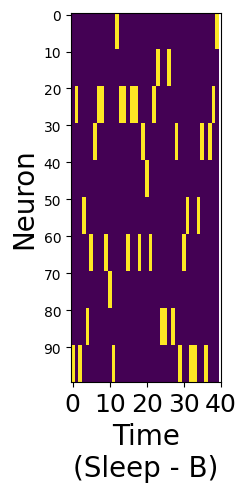

In [11]:
plt.imshow(torch.stack(network.activity_recordings["ctx"], dim=0)[network.sleep_indices_B][-input_params["day_length"]:][:, ordered_indices_ctx[:100]].reshape(-1, 100).T)
plt.yticks([])
plt.xticks([0, 10, 20, 30, 40], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time\n(Sleep - B)", fontsize=20)
plt.yticks(np.arange(0, 100, 10))

Text(0.5, 0, 'Time\n(Sleep - B)')

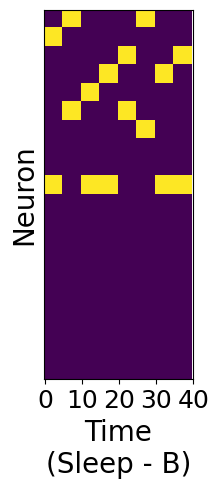

In [12]:
plt.imshow(torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-input_params["day_length"]:][:, ordered_indices_sparse[:100]].reshape(-1, 100).T)
plt.yticks([])
plt.xticks([0, 10, 20, 30, 40], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time\n(Sleep - B)", fontsize=20)

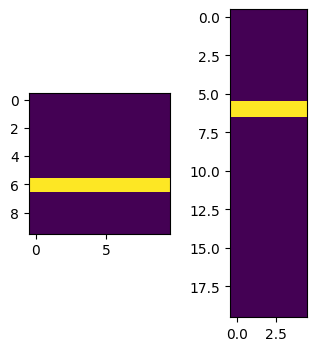

In [55]:
mtl = network.mtl_generate(semantic_charge=1)
fig, ax = plt.subplots(1, 2, figsize=(4, 4))
ax[0].imshow(mtl[:100].reshape((-1, 10)))
ax[1].imshow(mtl[100:][ordered_indices_sparse[:100]].reshape((-1, 5)))

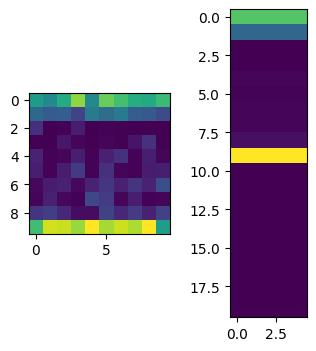

In [63]:
mtl_hat = network.mtl_mtl @ mtl
fig, ax = plt.subplots(1, 2, figsize=(4, 4))
ax[0].imshow(mtl_hat[:100].reshape((-1, 10)))
ax[1].imshow(mtl_hat[100:][ordered_indices_sparse[:100]].reshape((-1, 5)))

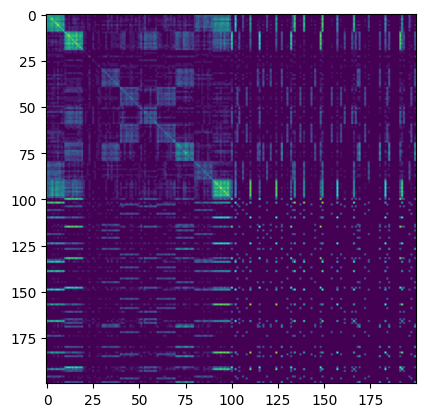

In [65]:
plt.imshow(network.mtl_mtl)

Text(0.5, 0, 'Neuron (Pre)')

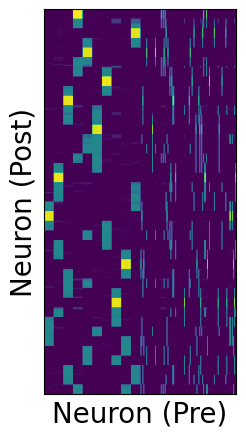

In [107]:
_, order_ctx_ctx, w_ctx_ctx = get_ordered_weights(network.ctx_ctx, order_columns=True)
_, order_mtl_sparse_ctx_A, w_mtl_sparse_ctx = get_ordered_weights(network.mtl_sparse_ctx)
_, order_mtl_sparse_ctx_B, w_mtl_sparse_ctx = get_ordered_weights(w_mtl_sparse_ctx.T)
_, order_mtl_sparse_ctx_C, w_mtl_sparse_ctx = get_ordered_weights(w_mtl_sparse_ctx.T)
_, order_ctx_mtl, w_ctx_mtl = get_ordered_weights(network.ctx_mtl)
_, order_ctx_mtl_sparse_A, w_ctx_mtl_sparse = get_ordered_weights(network.ctx_mtl_sparse)
_, order_ctx_mtl_sparse_B, w_ctx_mtl_sparse = get_ordered_weights(w_ctx_mtl_sparse.T)


fig = plt.figure(figsize=((5, 5)))
plt.imshow(w_ctx_mtl)
plt.xticks([])
plt.yticks([])
plt.ylabel("Neuron (Post)", fontsize=20)
plt.xlabel("Neuron (Pre)", fontsize=20)

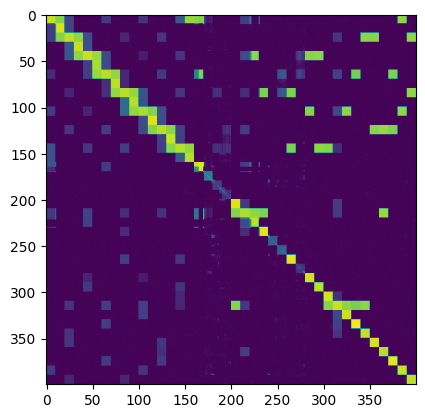

In [108]:
plt.imshow(w_ctx_ctx)

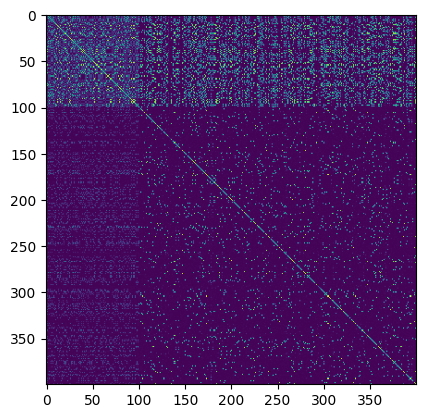

In [38]:
plt.imshow(network.ctx_ctx)

In [7]:
#torch.save(network, 'network_1500.pt')
#network = torch.load('network_2000.pt', weights_only=False)
network = torch.load('network_1500.pt', weights_only=False)

In [7]:
X_mtl_dense = torch.tensor(np.array(network.activity_recordings["mtl_dense"])[network.awake_indices][-500*input_params["day_length"]:])
X_mtl_sparse =  torch.tensor(np.array(network.activity_recordings["mtl_sparse"])[network.awake_indices][-500*input_params["day_length"]:])


In [8]:
X_latent_A = F.one_hot(input_latents[-500:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-500:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)

In [9]:
# Flatten time
days, day_length, num_latents = X_latent_AB.shape
_, num_neurons = X_mtl_dense.shape

latents_flat = X_latent_AB.reshape(-1, num_latents).float()    # shape: (days * day_length, num_latents)
neurons_dense_flat = X_mtl_dense.reshape(-1, num_neurons).float()    # shape: (days * day_length, num_neurons)
neurons_sparse_flat = X_mtl_sparse.reshape(-1, num_neurons).float()    # shape: (days * day_length, num_neurons)

# Normalize (zero mean, unit variance)
latents_norm = (latents_flat - latents_flat.mean(dim=0)) / latents_flat.std(dim=0)
neurons_dense_norm = (neurons_dense_flat - neurons_dense_flat.mean(dim=0)) / neurons_dense_flat.std(dim=0)
neurons_sparse_norm = (neurons_sparse_flat - neurons_sparse_flat.mean(dim=0)) / neurons_sparse_flat.std(dim=0)


# Compute correlation (selectivity): (num_neurons, num_latents)
selectivity_dense = neurons_dense_norm.T @ latents_norm / latents_norm.shape[0]
selectivity_sparse = neurons_sparse_norm.T @ latents_norm / latents_norm.shape[0]

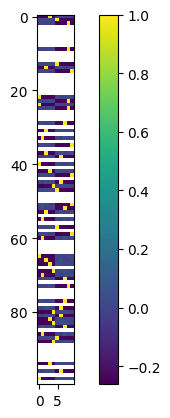

In [10]:
plt.imshow(selectivity_sparse)
plt.colorbar()

In [11]:
threshold = 0.9
num_neurons, num_latents = selectivity_sparse.shape

# Identify the latent with the highest selectivity per neuron
max_selectivity, max_latent_idx = selectivity_sparse.max(dim=1)

# Assign neurons to latents if selectivity >= threshold, else assign -1 (non-selective)
assigned_latents = torch.where(max_selectivity >= threshold, max_latent_idx, -1)

# Generate reordered indices
ordered_indices = []

# Iterate over each latent to collect selective neurons
for latent in range(num_latents):
    latent_neurons = (assigned_latents == latent).nonzero(as_tuple=True)[0]
    ordered_indices.append(latent_neurons)

# Add non-selective neurons at the end
non_selective_neurons = (assigned_latents == -1).nonzero(as_tuple=True)[0]
ordered_indices.append(non_selective_neurons)

# Concatenate indices into a single ordering
ordered_indices = torch.cat(ordered_indices)


In [12]:
network

SESNetwork()

In [13]:
ordered_indices

tensor([31, 33, 46, 66, 88,  6, 32, 71, 85, 95,  7, 34, 51, 75, 98, 29, 40, 58,
        67, 68,  5, 11, 15, 22, 62, 10, 12, 44, 53, 99, 28, 49, 52, 96, 97, 13,
        26, 60, 79, 81, 24, 36, 38, 87, 89,  0,  1,  2,  3,  4,  8,  9, 14, 16,
        17, 18, 19, 20, 21, 23, 25, 27, 30, 35, 37, 39, 41, 42, 43, 45, 47, 48,
        50, 54, 55, 56, 57, 59, 61, 63, 64, 65, 69, 70, 72, 73, 74, 76, 77, 78,
        80, 82, 83, 84, 86, 90, 91, 92, 93, 94])

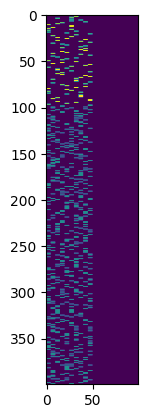

In [12]:
plt.imshow(network.ctx_mtl_sparse[:, ordered_indices])

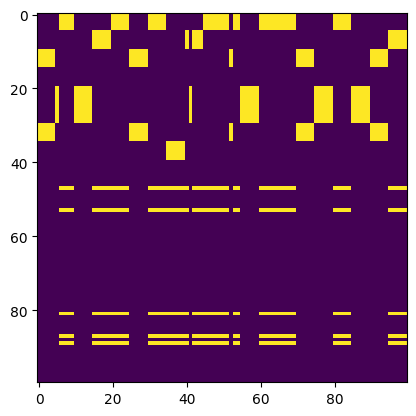

In [15]:
plt.imshow(np.array(network.activity_recordings["mtl_sparse"])[network.awake_indices][:, ordered_indices][-100:].T)

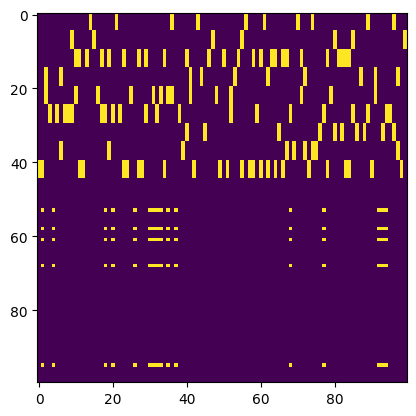

In [16]:
plt.imshow(np.array(network.activity_recordings["mtl_sparse"])[network.sleep_indices_A][:, ordered_indices][-100:].T)

In [53]:
X_mtl_sparse_sleep_A =  torch.tensor(np.array(network.activity_recordings["mtl_sparse"])[network.sleep_indices_A][-500*10:])

In [54]:
import torch

# Binary version of activity: 1 if neuron is active, 0 otherwise
activity = (X_mtl_sparse_sleep_A[:, ordered_indices] > 0).int()  # shape (timesteps, neurons)

# We need to recover the latent label for each neuron in the reordered order
# So we apply the same reordering to `assigned_latents` used earlier
assigned_latents_ordered = assigned_latents[ordered_indices]  # (neurons,)

# Build a latent mask for first 5 latents and last 5 latents
first_half_mask = torch.isin(assigned_latents_ordered, torch.arange(0, 5))
second_half_mask = torch.isin(assigned_latents_ordered, torch.arange(5, 10))

# Extract activity for first and second half
first_half_activity = activity[:, first_half_mask]          # (timesteps, N1)
second_half_activity = activity[:, second_half_mask]        # (timesteps, N2)
first_half_latents = assigned_latents_ordered[first_half_mask]
second_half_latents = assigned_latents_ordered[second_half_mask]

def different_latents_active(activity_sub, latents_sub):
    """
    Returns a boolean tensor (timesteps,) where at least two different latents are active.
    """
    # Expand dims to broadcast: (timesteps, neurons) & (neurons,)
    expanded_latents = latents_sub.unsqueeze(0).expand(activity_sub.size(0), -1)

    # Mask latents per timestep: zeros where neuron not active
    active_latents = expanded_latents * activity_sub

    # Count how many unique *non-zero* latents are active at each timestep
    # Using set on each row is slow, so we use a histogram trick instead:
    unique_latents = []
    for t in range(activity_sub.size(0)):
        latents_t = active_latents[t]
        latents_t = latents_t[latents_t > 0]  # remove inactive (0)
        unique = torch.unique(latents_t)
        unique_latents.append(len(unique))
    unique_latents = torch.tensor(unique_latents)

    return unique_latents >= 2  # (timesteps,) boolean

# Check each half
first_half_condition = different_latents_active(first_half_activity, first_half_latents)
second_half_condition = different_latents_active(second_half_activity, second_half_latents)

# Combine
timesteps_with_different_latents = torch.nonzero(first_half_condition | second_half_condition, as_tuple=True)[0]

print("Timesteps with ≥2 neurons from different latents (within halves):", timesteps_with_different_latents)

Timesteps with ≥2 neurons from different latents (within halves): tensor([4051, 4097, 4109, 4135, 4152, 4175, 4234, 4246, 4477, 4512, 4516, 4518,
        4592, 4641, 4660, 4675, 4740, 4758, 4844, 4866, 4895, 4921, 4942, 4955,
        4982, 4984, 4992])


In [58]:
timesteps_with_different_latents

tensor([4051, 4097, 4109, 4135, 4152, 4175, 4234, 4246, 4477, 4512, 4516, 4518,
        4592, 4641, 4660, 4675, 4740, 4758, 4844, 4866, 4895, 4921, 4942, 4955,
        4982, 4984, 4992])

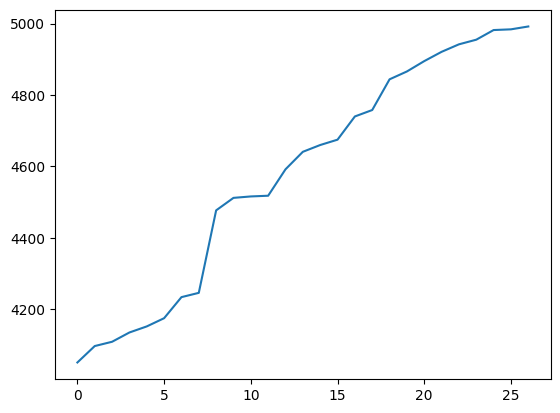

In [60]:
plt.plot(timesteps_with_different_latents.flatten())

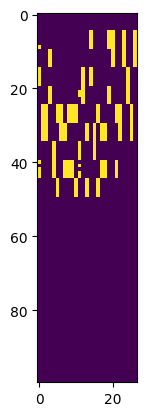

In [55]:
plt.imshow(X_mtl_sparse_sleep_A[timesteps_with_different_latents][:, ordered_indices].T)

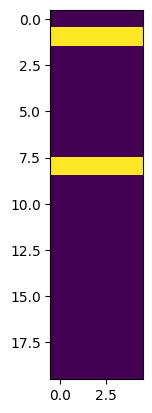

In [15]:
plt.imshow(np.array(network.activity_recordings["mtl_sparse"])[network.sleep_indices_A][:, ordered_indices][1500*10 + 70].reshape((-1, 5)))

In [16]:
mtl_sparse = np.array(network.activity_recordings["mtl_sparse"])[network.sleep_indices_A][1500*10 + 70]
mtl_sparse_mtl_sparse = np.array(network.connectivity_recordings["mtl_sparse_mtl_sparse"])[network.sleep_indices_A][1500*10 + 70]
mtl_sparse_mtl_sparse[torch.eye(mtl_sparse_mtl_sparse.shape[0], dtype=bool)] = 0

pc_hat = mtl_sparse @ mtl_sparse_mtl_sparse

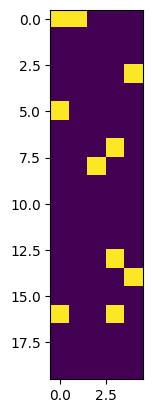

In [17]:
plt.imshow(network.activation(torch.tensor(pc_hat), 'mtl_sparse')[0].reshape((-1, 5)))

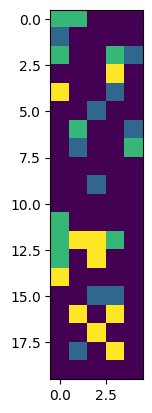

In [29]:
plt.imshow(pc_hat.reshape((-1, 5)))

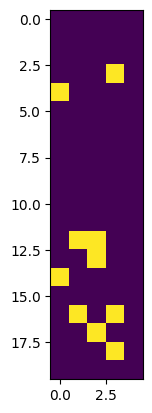

In [25]:
plt.imshow(mtl_sparse.reshape((-1, 5)))

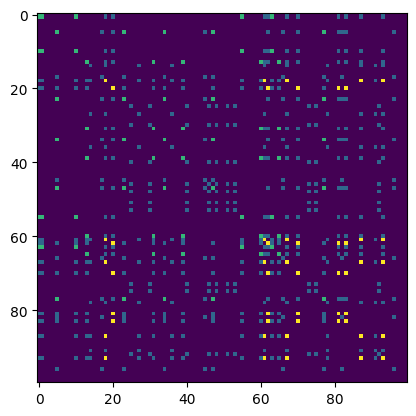

In [23]:
plt.imshow()

In [18]:
# Flatten time dimension
latents_flat = X_latent_AB.reshape(-1, X_latent_AB.shape[-1])       # (T, num_latents)
neurons_flat = X_mtl_dense.reshape(-1, X_mtl_dense.shape[-1])       # (T, num_neurons)

# Define presence threshold
threshold = 0.5
present_mask = latents_flat > threshold                     # (T, num_latents)

# Compute overall mean firing rate per neuron
mean_firing = neurons_flat.mean(dim=0)                      # (num_neurons,)

# Initialize selectivity matrix
num_neurons = X_mtl_dense.shape[-1]
num_latents = X_latent_AB.shape[-1]
selectivity = torch.zeros(num_neurons, num_latents)

# Loop over latents
for j in range(num_latents):
    mask_on = present_mask[:, j]                            # (T,)
    mask_off = ~mask_on                                     # Inverse
    
    # Mean firing when latent j is present/absent
    mean_on = neurons_flat[mask_on].mean(dim=0)             # (num_neurons,)
    mean_off = neurons_flat[mask_off].mean(dim=0)           # (num_neurons,)
    
    # Compute selectivity for all neurons for latent j
    selectivity[:, j] = (mean_on - mean_off)

In [19]:
X_mtl_dense = torch.tensor(np.array(network.activity_recordings["mtl_dense"][-500*input_params["day_length"]:]))
X_mtl_sparse =  torch.tensor(np.array(network.activity_recordings["mtl_sparse"][-500*input_params["day_length"]:]))

X_latent_A = torch.repeat_interleave(F.one_hot(input_latents[:, :, 0].long(), num_classes=latent_specs["dims"][0]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_B = torch.repeat_interleave(F.one_hot(input_latents[:, :, 1].long(), num_classes=latent_specs["dims"][1]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=1)
X_latent = torch.zeros((X_latent_AB.shape[0], 100))
X_latent[:X_latent_AB.shape[0], :X_latent_AB.shape[1]] = X_latent_AB

In [20]:


X_latent_A = F.one_hot(input_latents[:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = torch.repeat_interleave(F.one_hot(input_latents[:, :, 1].long(), num_classes=latent_specs["dims"][1]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=1)
X_latent = torch.zeros((X_latent_AB.shape[0], 100))
X_latent[:X_latent_AB.shape[0], :X_latent_AB.shape[1]] = X_latent_AB

RuntimeError: Tensors must have same number of dimensions: got 3 and 2

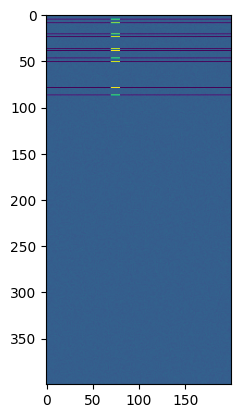

In [16]:
plt.imshow(network.ctx_mtl)

In [30]:
_, order_ctx_ctx, w_ctx_ctx = get_ordered_weights(network.ctx_ctx, order_columns=True)
_, order_mtl_sparse_ctx_A, w_mtl_sparse_ctx = get_ordered_weights(network.mtl_sparse_ctx)
_, order_mtl_sparse_ctx_B, w_mtl_sparse_ctx = get_ordered_weights(w_mtl_sparse_ctx.T)
_, order_mtl_sparse_ctx_C, w_mtl_sparse_ctx = get_ordered_weights(w_mtl_sparse_ctx.T)
_, order_ctx_mtl, w_ctx_mtl = get_ordered_weights(network.ctx_mtl)
_, order_ctx_mtl_sparse_A, w_ctx_mtl_sparse = get_ordered_weights(network.ctx_mtl_sparse)
_, order_ctx_mtl_sparse_B, w_ctx_mtl_sparse = get_ordered_weights(w_ctx_mtl_sparse.T)


fig = plt.figure(figsize=((5, 5)))
plt.imshow(w_ctx_mtl)
plt.xticks([])
plt.yticks([])
plt.ylabel("Neuron (Post)", fontsize=20)
plt.xlabel("Neuron (Pre)", fontsize=20)

Text(0.5, 0, 'Neuron (Pre)')

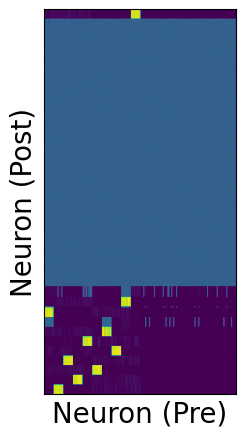

In [31]:
fig = plt.figure(figsize=((5, 5)))
plt.imshow(w_ctx_mtl)
plt.xticks([])
plt.yticks([])
plt.ylabel("Neuron (Post)", fontsize=20)
plt.xlabel("Neuron (Pre)", fontsize=20)

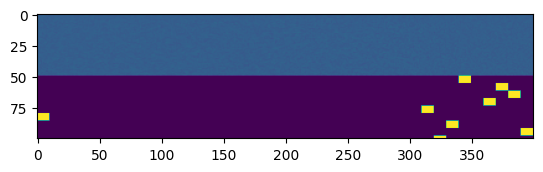

In [19]:
plt.imshow(w_mtl_sparse_ctx)

In [20]:
w_ctx_mtl_sparse.shape

torch.Size([100, 400])

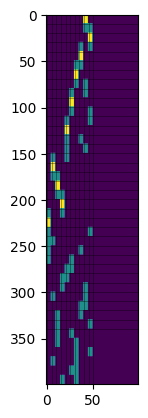

In [22]:
plt.imshow(w_ctx_mtl_sparse.T)


for i in range(35):
  plt.axhline(i*10 - 0.5, linewidth=0.5, color='black', alpha=0.5)

for i in range(11):
  plt.axvline(i*5 + 0.5, linewidth=0.5, color='black', alpha=0.5)



In [29]:
def mtl_generate(network, semantic_charge, num_iterations=None):
    num_iterations = num_iterations  if num_iterations != None else getattr(network, 'mtl_generate_pattern_complete_iterations')
    mtl_sparsity = (semantic_charge/network.max_semantic_charge)*network.mtl_sparsity
    mtl_random = torch.randn(network.mtl_size)**2
    h = network.pattern_complete('mtl', h_0=mtl_random, h_conditioned=None, num_iterations=num_iterations, sparsity=mtl_sparsity)
    return h

In [32]:
order_mtl_sparse_ctx_C

[0,
 tensor(1),
 tensor(2),
 tensor(3),
 tensor(4),
 tensor(5),
 tensor(6),
 tensor(7),
 tensor(8),
 tensor(9),
 tensor(10),
 tensor(11),
 tensor(12),
 tensor(13),
 tensor(14),
 tensor(15),
 tensor(16),
 tensor(17),
 tensor(18),
 tensor(19),
 tensor(20),
 tensor(21),
 tensor(22),
 tensor(23),
 tensor(24),
 tensor(25),
 tensor(26),
 tensor(27),
 tensor(28),
 tensor(29),
 tensor(30),
 tensor(31),
 tensor(32),
 tensor(33),
 tensor(34),
 tensor(35),
 tensor(36),
 tensor(37),
 tensor(38),
 tensor(39),
 tensor(40),
 tensor(41),
 tensor(42),
 tensor(43),
 tensor(44),
 tensor(45),
 tensor(46),
 tensor(47),
 tensor(48),
 tensor(49),
 tensor(50),
 tensor(51),
 tensor(52),
 tensor(53),
 tensor(54),
 tensor(55),
 tensor(56),
 tensor(57),
 tensor(58),
 tensor(59),
 tensor(60),
 tensor(61),
 tensor(62),
 tensor(63),
 tensor(64),
 tensor(64),
 tensor(65),
 tensor(66),
 tensor(67),
 tensor(68),
 tensor(69),
 tensor(69),
 tensor(70),
 tensor(71),
 tensor(72),
 tensor(73),
 tensor(74),
 tensor(74),
 ten

In [68]:
mtl = network.mtl_generate(semantic_charge = 1)

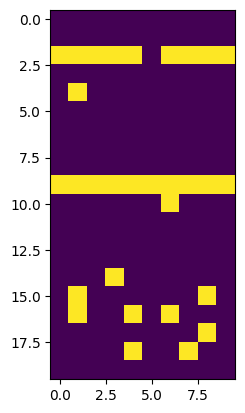

In [69]:
plt.imshow(mtl.reshape((-1, 10)))

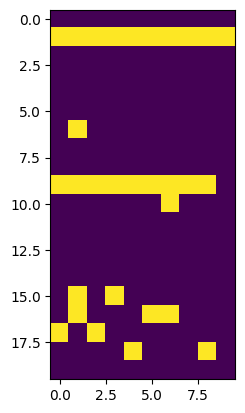

In [64]:
plt.imshow(mtl.reshape((-1, 10)))

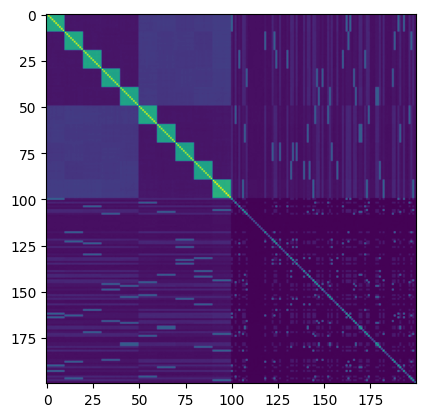

In [41]:
plt.imshow(network.mtl_mtl)

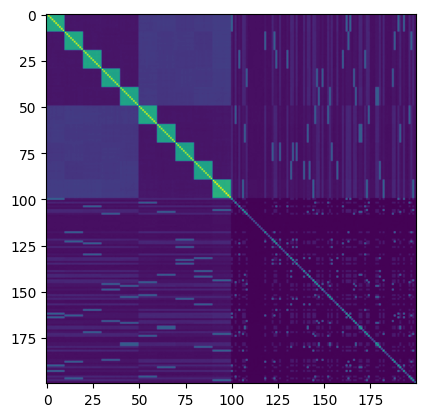

In [45]:
plt.imshow(network.mtl_mtl_plastic)

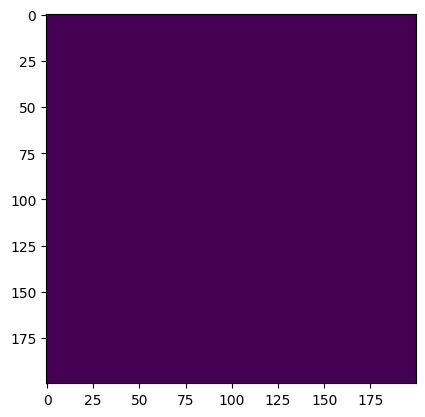

In [46]:
plt.imshow(network.mtl_mtl_fixed)

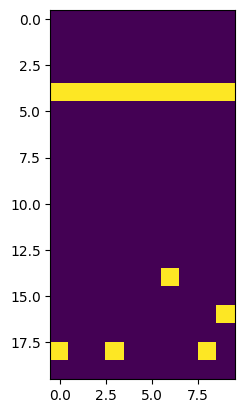

In [45]:
plt.imshow(mtl.reshape((-1, 10)))

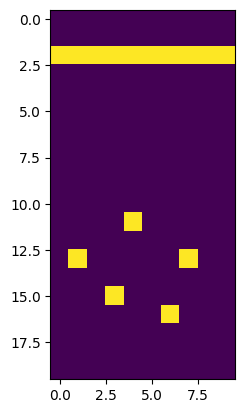

In [43]:
plt.imshow(mtl.reshape((-1, 10)))

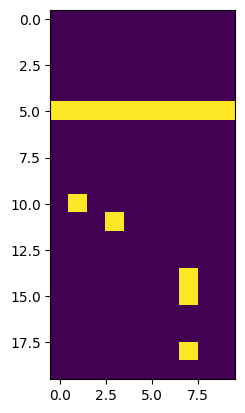

In [41]:
plt.imshow(mtl.reshape((-1, 10)))

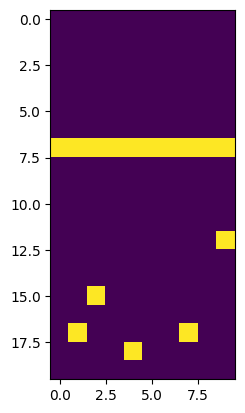

In [39]:
plt.imshow(mtl.reshape((-1, 10)))

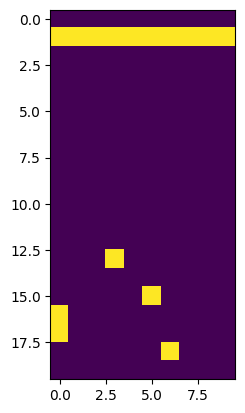

In [31]:
plt.imshow(mtl.reshape((-1, 10)))

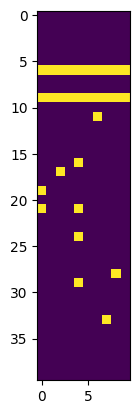

In [32]:
plt.imshow(torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-16, order_ctx_ctx].reshape((-1, 10)))

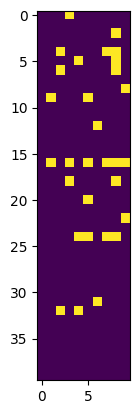

In [35]:
plt.imshow(torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-16, order_ctx_mtl_sparse_A].reshape((-1, 10)))

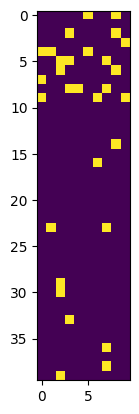

In [18]:
plt.imshow(torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-1].reshape((-1, 10)))

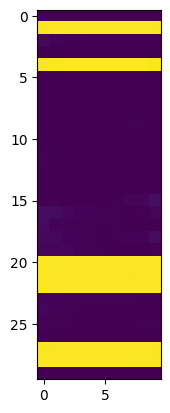

In [23]:
plt.imshow(torch.stack(network.activity_recordings["ctx_hat"], dim=0)[network.awake_indices][-1, order_ctx_mtl_sparse_A][100:].reshape((-1, 10)))

In [35]:
ctx_hat = torch.stack(network.activity_recordings["ctx_hat"], dim=0)[network.awake_indices][-1, order_ctx_mtl_sparse_A]

In [36]:
ctx_hat[network.ctx_subregions[1]] = network.activation(ctx_hat, 'ctx', subregion_index=1)[0][network.ctx_subregions[1]]

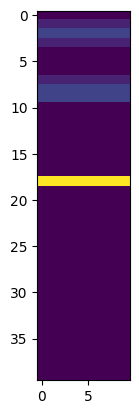

In [37]:
plt.imshow(ctx_hat.reshape((-1, 10)))